In [1]:
%matplotlib inline 

from collections import defaultdict
import datetime
import glob 
import math
import itertools
import os 
import functools

import numpy as np
import pysam
import scipy
import seaborn as sns
from matplotlib import gridspec
import matplotlib
import pandas as pd
from IPython.core.display import HTML
import sklearn
from sklearn.metrics import r2_score

from gscripts import qtools
from gscripts.encode import encode_helpers
from gscripts.general import parsers
from gscripts.general import dataviz

sns.set_style("darkgrid")
sns.set_style("ticks")

img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2"
xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))



In [2]:
#Unique Reads to estimate on
unique = "unique"

#what do I want to call unique reads?
unique_reads = "Unique Molecules"

In [3]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rbp_colors = encode_helpers.get_rbp_color_chooser()

# Load Already Generated Data for Visualization

In [4]:
#Get all counts, but count only things that we plan on submitting
merged_data = encode_helpers.get_merged_data()
#Filter out anything sequenced after 16/7/18
merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]

counts_list = pd.read_csv("downsample_counts_full_v5.csv", dtype={"RBP_ID": str, "bio_rep": str, "tech_rep": str})
counts_list = counts_list.set_index(["RBP_ID", "RBP", "bio_rep", "tech_rep", "fraction"])
counts_list = counts_list.loc[list(merged_data.index.get_level_values(level=0))]

In [5]:
len(merged_data) * 2, len(counts_list.xs(1.0, level="fraction"))

(1308, 1308)

In [6]:
# colors = sns.color_palette("Set2", 4)

# num_rows = len(counts_list.groupby(level=["RBP_ID", "RBP"])) + 1
# num_cols = 3

# print num_rows

# actual_num_rows = 20
# #number of plots is too large, need to shrink
# for plot_num in range(num_rows / actual_num_rows):
#     with dataviz.Figure(os.path.join(img_dir, "downsampling_bam_{}.svg".format(plot_num)), figsize=(4 * num_cols, 4 * actual_num_rows)) as fig:
#         gs = gridspec.GridSpec(actual_num_rows, num_cols)
#         print plot_num * actual_num_rows, (plot_num + 1) * actual_num_rows
#         for x, (rbp_name, rbp_row) in enumerate(list(counts_list.groupby(level=["RBP_ID", "RBP"]))[plot_num * actual_num_rows : (plot_num + 1) * actual_num_rows]):
#             for color, (name, row) in enumerate(rbp_row.groupby(level=[2,3])):
                
#                 z = np.polyfit(x=row.uncollapsed, y=row[unique], deg=2)
#                 p = np.poly1d(z)

#                 ax = fig.add_subplot(gs[x,0])
                
#                 ax.plot(row.uncollapsed, row[unique], color=colors[color], label="_".join(name), linewidth=4, alpha=.7)
#                 ax.plot(row.uncollapsed, p(row.uncollapsed), color=colors[color], label="_".join(name), 
#                         linewidth=4, alpha=.7, linestyle='dashed' )

#                 ax.set_title("Usable vs Mapped")
#                 ax.set_xlim(0, )
#                 ax.set_ybound(0, )
#                 ax.xaxis.set_major_formatter(xfmt)
#                 ax.yaxis.set_major_formatter(xfmt)
#                 ax.set_xlabel("Input Reads (M)")
#                 ax.set_ylabel("{}\nUsable Reads (M)".format(" ".join(rbp_name)))

#                 fraction_usable = row[unique] / row.uncollapsed

#                 ax = fig.add_subplot(gs[x,1])
#                 ax.plot(row.uncollapsed, fraction_usable, color=colors[color], label="_".join(name), linewidth=4, alpha=.7)

#                 ax.set_title("Mapped vs Fraction Usable")
#                 ax.set_xlim(0, )
#                 ax.set_ybound(0, 1)
#                 ax.xaxis.set_major_formatter(xfmt)
#                 ax.set_xlabel("Reads (M)")
#                 ax.set_ylabel("Fraction Usable")

#                 row = row.astype(float)
#                 fraction_recovered = (row[unique][1:].values - row[unique][:-1].values) / (row.uncollapsed[1:].values - row.uncollapsed[:-1].values) * 1.0

#                 ax = fig.add_subplot(gs[x,2])
#                 ax.plot(row.uncollapsed, fraction_usable, color=colors[color], label="_".join(name), linewidth=4, alpha=.7)

#                 ax.set_title("Mapped vs Fraction Recovered")
#                 ax.set_xlim(0, )
#                 ax.set_ybound(0, 1)
#                 ax.xaxis.set_major_formatter(xfmt)
#                 ax.set_xlabel("Reads (M)")
#                 ax.set_ylabel("Fraction Recovered")
#                 ax.legend()

# Representitive figures for lab meeting / paper

Unsaturated RBPs
204
206

RBPs on the way to Saturating 
216
328

Saturated RBPs 
262 - LARP7 (combine)
298 - LARP7

Most RBPs aren't saturating, maybe come up with a metric for this?

For paper quality figure need to select a few to show, follow up with correlation to eCT describing saturation.  fraction usable might not be perfect because it doesn't take into account sequencing depth, I'll plot and see, 

Also the technical replicates have the same eCT value and are effectively the same, so I'm going to combine them downstream

# Generate Merged eCT and read dataframe

In [7]:
eCT_data = pd.read_table("/home/elvannostrand/data/ENCODE/project_stuff/ENCODE_CLIP_alldata_20170313.txt", 
                         index_col=0, 
                         skiprows=1,
                        na_values=["#NUM!", "#VALUE!", "x"])
eCT_data = eCT_data.dropna(how="all", axis=1).dropna(how="all", axis=0)

#These are the eCT values for rep1, rep2 and input as per Erics note
eCT_data = eCT_data[[eCT_data.columns[20], eCT_data.columns[22], eCT_data.columns[23], 
                     eCT_data.columns[30], eCT_data.columns[32], eCT_data.columns[33], 
                     eCT_data.columns[40], eCT_data.columns[42], eCT_data.columns[43]]]

#Clean data, lets see how much goes away when I delete everything without an eCT
eCT_data = eCT_data.dropna(how="all", axis=0)

#Convert to string for joining on my qc numbers
eCT_data.index = [str(int(item)) for item in eCT_data.index]
eCT_data.columns = ["cycle_num_rep1", "concentration_rep1", "eCT_rep1", 
                    "cycle_num_rep2", "concentration_rep2", "eCT_rep2", 
                    "cycle_num_input", "concentration_input", "eCT_input"]

In [8]:
#Fixes issue with two samples coming from a different uID
eCT_data = eCT_data.set_value("214", "eCT_rep2", eCT_data.ix["234"].eCT_rep1)
eCT_data = eCT_data.set_value("214", "concentration_rep2", eCT_data.ix["234"].concentration_rep1)
eCT_data = eCT_data.set_value("214", "cycle_num_rep2", eCT_data.ix["234"].cycle_num_rep1)

In [9]:
len(counts_list.xs(1.0, level="fraction").groupby(level=["RBP_ID", "RBP"]).sum())

327

In [10]:
#this code merges the two techincal replicates
counts_list_merged = counts_list.groupby(level=["RBP_ID","RBP","bio_rep","fraction"]).sum()
counts_list_merged['uID'] = counts_list_merged.index.get_level_values(level=0)
counts_list_merged['uID'] = counts_list_merged.uID.apply(lambda x:x.split("x")[0])
#Join with eCT
eCT_and_usable = pd.merge(counts_list_merged, eCT_data, left_on="uID", right_index=True, how="left")

#Just get one eCT value for each rep
eCT_and_usable = eCT_and_usable.swaplevel("bio_rep", "fraction").unstack()
eCT_and_usable = eCT_and_usable[[('uncollapsed', '01'), 
                ('uncollapsed', '02'),
                ('unique', '01'),
                ('unique', '02'),
#                 ('directional', '01'),
#                 ('directional', '02'),
                ('genomic_uncollapsed', '01'),
                ('genomic_uncollapsed', '02'),
                ('genomic_unique', '01'),
                ('genomic_unique', '02'),

                ('eCT_rep1', '01'),
                ('eCT_rep2', '02'),
                ('concentration_rep1', '01'),
                ('concentration_rep2', '02'),
                ('cycle_num_rep1', '01'),
                ('cycle_num_rep2', '02')]].stack().swaplevel("bio_rep", "fraction").sort_index()

eCT_and_usable['eCT'] = pd.concat([eCT_and_usable['eCT_rep1'].dropna(), eCT_and_usable['eCT_rep2'].dropna()]).reindex_like(eCT_and_usable).astype(float)
eCT_and_usable['concentration'] = pd.concat([eCT_and_usable['concentration_rep1'].dropna(), eCT_and_usable['concentration_rep2'].dropna()]).reindex_like(eCT_and_usable).astype(float)
eCT_and_usable['cycle_num'] = pd.concat([eCT_and_usable['cycle_num_rep1'].dropna(), eCT_and_usable['cycle_num_rep2'].dropna()]).reindex_like(eCT_and_usable).astype(float)

#Cleanup results
eCT_and_usable = eCT_and_usable.drop(["eCT_rep1", 'eCT_rep2'], axis=1)
eCT_and_usable = eCT_and_usable.drop(["concentration_rep1", 'concentration_rep2'], axis=1)
eCT_and_usable = eCT_and_usable.drop(["cycle_num_rep1", 'cycle_num_rep2'], axis=1)

#eCT_and_usable = eCT_and_usable.dropna(how="any")

#Calculate more summary stats
eCT_and_usable['log_uncollapsed'] = np.log10(eCT_and_usable.uncollapsed)
eCT_and_usable['fraction_usable'] = eCT_and_usable[unique] / eCT_and_usable.uncollapsed

eCT_and_usable.to_csv("/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/data/eCT_and_usable.csv")

In [11]:
print "datasets with missing eCT values, some might still be missing" 
eCT_and_usable[eCT_and_usable.isnull().eCT]

datasets with missing eCT values, some might still be missing


Empty DataFrame
Columns: [genomic_uncollapsed, genomic_unique, uncollapsed, unique, eCT, concentration, cycle_num, log_uncollapsed, fraction_usable]
Index: []

# Raw observation eCT to final usable reads

In [12]:
total_usable = eCT_and_usable.xs(1.0, level="fraction")

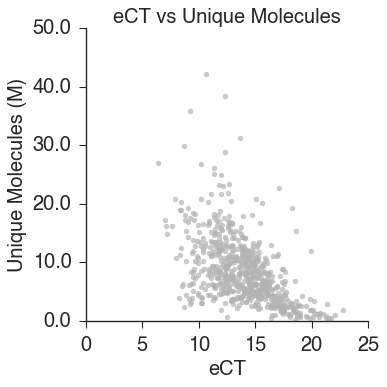

In [13]:
num_cols = 1
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.scatter(total_usable.eCT, total_usable[unique], alpha=.7, color=".7")
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("{} (M)".format(unique_reads), fontsize=18)
    ax.set_xlabel("eCT", fontsize=18)
    ax.set_title("eCT vs {}".format(unique_reads), fontsize=18)
    sns.despine(ax=ax)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlim(0)
    ax.set_ylim(0)

# Does eCT correlate to slope?
Don't quite know what function to fit, so I'm just going to plot it for the sake of ease, see what comes out

In [14]:
#sorts everything by eCT and preservers other orders
grp = eCT_and_usable.groupby(level=['RBP_ID', "RBP", "bio_rep"])
eCT_and_usable = eCT_and_usable.ix[grp[['eCT']].transform(max).sort_values("eCT").index]

f = lambda x: x.sort_index(level="fraction")

eCT_and_usable = eCT_and_usable.groupby(level=['RBP_ID', "RBP", "bio_rep"], sort=False).apply(f)
eCT_and_usable.index = eCT_and_usable.index.droplevel(level=[0,1,2])

4 21


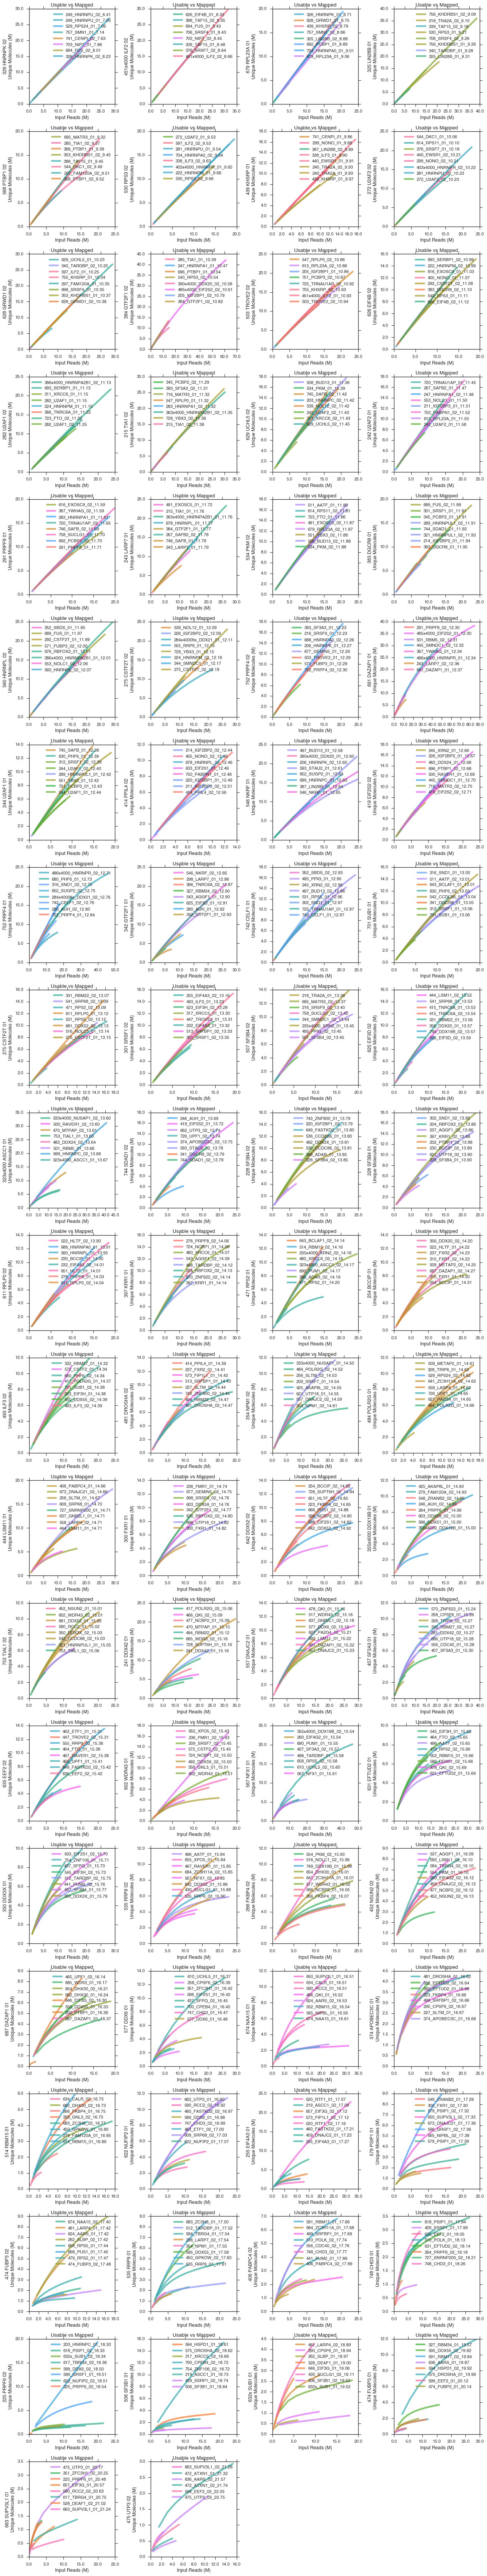

In [15]:
actual_num_rows = 8

colors = sns.color_palette("Set2", actual_num_rows)
xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))

#Number of plots we'll be making, given actual_num_rows events per plot
num_plots = int(math.ceil(len(eCT_and_usable.groupby(level=["RBP_ID", "RBP", "bio_rep"])) / float(actual_num_rows)))

num_cols = 4
num_rows = int(math.ceil(num_plots / float(num_cols)))

print num_cols, num_rows
grp = eCT_and_usable.groupby(level=['RBP_ID', "RBP", "bio_rep"], sort=False)
with dataviz.Figure(os.path.join(img_dir, "grouped_downsampling.png"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
    for plot_num in range(num_plots):
        ax = fig.add_subplot(num_rows, num_cols, plot_num + 1)
        for x, (rbp_name, rbp_row) in enumerate(list(grp)[plot_num * actual_num_rows : (plot_num + 1) * actual_num_rows]):
            rbp_row = rbp_row.sort_index()
            ect = "{:.2f}".format(rbp_row.eCT.values[0])
            ax.plot(rbp_row.uncollapsed, 
                    rbp_row[unique], 
                    color=rbp_colors.ix[rbp_name[1]].rgb, 
                    label="_".join(list(rbp_name) + [ect]), 
                    linewidth=4, alpha=.7)
#             ax.plot(rbp_row.uncollapsed, 
#                     rbp_row.directional, 
#                     color=rbp_colors.ix[rbp_name[1]].rgb, 
#                     label="_".join(list(rbp_name) + [ect]), 
#                     linewidth=4, 
#                     alpha=.7,
#                    linestyle="--")
        ax.set_title("Usable vs Mapped")
        ax.set_xlim(0, )
        ax.set_ybound(0, )
        ax.xaxis.set_major_formatter(xfmt)
        ax.yaxis.set_major_formatter(xfmt)
        ax.set_xlabel("Input Reads (M)")
        ax.set_ylabel("{}\n{} (M)".format(" ".join(rbp_name), unique_reads))
        ax.legend()               

So this is cool, there is a storng correlation between usable reads and eCT, howoever that correlation breaks down somewhat middle and high eCT values.  Pretty darastically in some cases.  This could be caused by not taking into account reads mapped out due to repetitive element removal.  

I looked at using a slightly better duplciate removal algorithm and it didn't help.  At this point its commented out



# eCT is correlated with satuation rates.  

In [16]:
eCT_and_usable = eCT_and_usable.sort_index()

#I just selected a random representetive set of RPBs out of all our data
plotted_ect_and_usable = eCT_and_usable.loc[['249','719', '204','466','262']]
plotted_ect_and_usable = plotted_ect_and_usable.xs("01", level=2)
plotted_ect_and_usable = plotted_ect_and_usable.sort_values("eCT")

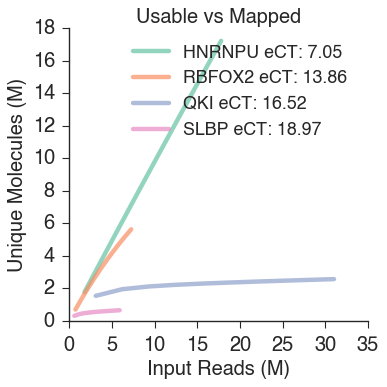

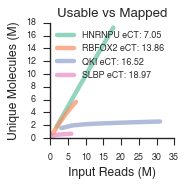

In [17]:
colors = sns.color_palette("Set2", 4)
xfmt_int = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(float(x) / 1000000), ','))

grp = plotted_ect_and_usable.groupby(level=['RBP_ID', "RBP"], sort=False)
with dataviz.Figure(os.path.join(img_dir, "ect_explanatory_figure_presentation.svg"), figsize=(5 * 1, 5 * 1)) as fig:
    ax = fig.add_subplot(1, 1, 1)
    for x, (rbp_name, rbp_row) in enumerate(list(grp)):
        rbp_row = rbp_row.sort_index()
        ect = "{:.2f}".format(rbp_row.eCT.values[0])
        ax.plot(rbp_row.uncollapsed, rbp_row[unique], 
                color=colors[x], 
                label="{} eCT: {} ".format(rbp_name[1], ect), 
                linewidth=4, 
                alpha=.7)
        
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_title("Usable vs Mapped", fontsize=18)
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Input Reads (M)", fontsize=18)
    ax.set_ylabel("{} (M)".format(unique_reads), fontsize=18)
    ax.legend(fontsize=16)
    sns.despine(ax=ax)
    
with dataviz.Figure(os.path.join(img_dir, "ect_explanatory_figure.svg"), figsize=(2.5 * 1, 2.5 * 1)) as fig:
    ax = fig.add_subplot(1, 1, 1)
    for x, (rbp_name, rbp_row) in enumerate(list(grp)):
        rbp_row = rbp_row.sort_index()
        ect = "{:.2f}".format(rbp_row.eCT.values[0])
        ax.plot(rbp_row.uncollapsed, rbp_row[unique], 
                color=colors[x], 
                label="{} eCT: {} ".format(rbp_name[1], ect), 
                linewidth=4, 
                alpha=.7)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    ax.set_title("Usable vs Mapped")
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Input Reads (M)")
    ax.set_ylabel("{} (M)".format(unique_reads))
    ax.legend(fontsize=8)
    sns.despine(ax=ax)

# Better paramaterize the total number of unique molecules in each dataset

We know a few things

fm = femptomoles or $1*10^{-15}$ moles

Remember Avagrods number is $6.0221409^{23}\frac{molecules}{mole}$

eCT=CT- $log_{eff}(\frac{total\_concentration (fm)}{100 (fm)})$

It follows that the total number of usable molecues in the library should be equal to

initial concentration = $\frac{100(fm)}{2^{eCT}}$ 

initial concentration = $100(fm) * 2^{-eCT}$ 

initial molecues = $2^{-eCT} * 100(fm) * 1*10^{-15} \frac{moles}{fm} * 6.0221409^{23}\frac{molecules}{mole}$ 

Keep in mind that the base in the eCT exponent may not be correct, but I'm not sure I can fix that right now.  

initial molecues is also my scale paramater, so this will help me paramaterize my data a bit better I think.

~Slope is $\frac{1}{total\_molecues}$ 

Remember, could just measure initial concentration directly, but we just don't do that.

If PCR efficency is lower than 2, thats going to throw off my eCT calculation in a way that makes it so I'm back to doing my two paramater estimation, and we can't actually estimate the total number of usable reads in the library accurately, and I've got to go back to providing best / worst cases. 

Potental Sources of Variation
1. PCR Efficency
2. Duplicate Reomval Stargaties

I know PCR efficency decreases as time continues, but I don't know how much by, and honestly I'm not sure estimating PCR efficency computationally is the best use of my time

I'm stuck here, finding a better way to estimate PCR efficency...

# Estimate PCR Duplication efficency for values lower than 2 using saturated datasets

In [18]:
def calc_initial_molecues(eCT):
    neg_ect = eCT * -1
    #This is avagadros number for femptomoles
    avagadros_number = 6.0221409 * np.power(10, 8)   
    initial_molecules = np.power(2, neg_ect) * 100 * avagadros_number
    return initial_molecules

def calc_initial_molecues_estimate(eCT, pcr_efficency):
    neg_ect = eCT * -1
    #This is avagadros number for femptomoles
    avagadros_number = 6.0221409 * np.power(10, 8)   
    #Something in my math is wrong here, I think but I'm not sure where I went wrong...
    initial_molecules = np.power(pcr_efficency, neg_ect) * 100 * avagadros_number
    return initial_molecules

def calc_initial_molecues_fit(eCT, unique):
    #I get these from math of trying to solve for a in the equation
    # y = a tanh(xb)
    #where y is number of duplicate removed reads, x is the number of input reads and a and b are free paramaters 
    p0 = [2]
    z = scipy.optimize.curve_fit(f=calc_initial_molecues_estimate, 
                                 xdata=eCT, 
                                 ydata=unique, 
                                 method="trf", 
                                 bounds=(0, 2),
                                 p0=p0)
    pcr_efficency = z[0][0]
    return pcr_efficency

In [19]:
saturated_datasets = total_usable[total_usable.fraction_usable < .10]
tight_pcr = calc_initial_molecues_fit(saturated_datasets.eCT, saturated_datasets[unique])

saturated_datasets = total_usable[total_usable.fraction_usable < .20]
relaxed_pcr = calc_initial_molecues_fit(saturated_datasets.eCT, saturated_datasets[unique])

calc_initial_molecues_estimate_tight = functools.partial(calc_initial_molecues_estimate, pcr_efficency=tight_pcr)
calc_initial_molecues_estimate_relaxed = functools.partial(calc_initial_molecues_estimate, pcr_efficency=relaxed_pcr)

eCT_and_usable['predicted_usable_molecules'] = eCT_and_usable.eCT.apply(calc_initial_molecues)
eCT_and_usable['predicted_usable_molecules_tight'] = eCT_and_usable.eCT.apply(calc_initial_molecues_estimate_tight)
eCT_and_usable['predicted_usable_molecules_relaxed'] = eCT_and_usable.eCT.apply(calc_initial_molecues_estimate_relaxed)

total_usable = eCT_and_usable.xs(1.0, level="fraction")

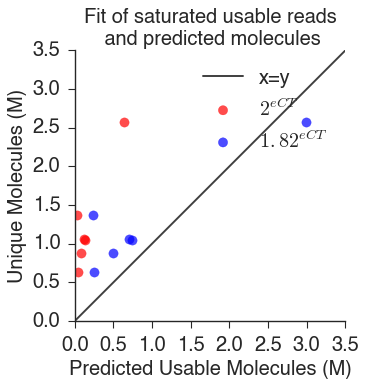

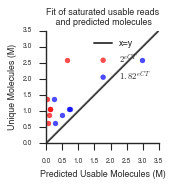

In [20]:
num_rows = 1
num_cols = 1

saturated_datasets = total_usable[total_usable.fraction_usable < .10]
linregress = scipy.stats.linregress(saturated_datasets.predicted_usable_molecules_tight,
                                    saturated_datasets[unique])
r2 = np.power(linregress.rvalue, 2)

with dataviz.Figure(os.path.join(img_dir, "estimated_reads_to_ect_presentation.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(saturated_datasets['predicted_usable_molecules'], saturated_datasets[unique], 
               s=70, alpha=.7, color='r', label="$2^{eCT}$")
    ax.scatter(saturated_datasets['predicted_usable_molecules_tight'], saturated_datasets[unique], 
               s=70, alpha=.7, color="b", label="${:.3}^{{eCT}}$".format(tight_pcr))

    ax.set_xlabel("Predicted Usable Molecules (M)", fontsize=18)
    ax.set_ylabel("{} (M)".format(unique_reads), fontsize=18)
    ax.set_title("Fit of saturated usable reads\n and predicted molecules", fontsize=18)
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlim(0,)
    ax.set_ylim(0,)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="x=y")
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend(fontsize=18)
    sns.despine(ax=ax)

with dataviz.Figure(os.path.join(img_dir, "estimated_reads_to_ect.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(saturated_datasets['predicted_usable_molecules'], saturated_datasets[unique], alpha=.7, color='r', label="$2^{eCT}$")
    ax.scatter(saturated_datasets['predicted_usable_molecules_tight'], saturated_datasets[unique], alpha=.7, color="b", label="${:.3}^{{eCT}}$".format(tight_pcr))

    ax.set_xlabel("Predicted Usable Molecules (M)", fontsize=8)
    ax.set_ylabel("{} (M)".format(unique_reads), fontsize=8)
    ax.set_title("Fit of saturated usable reads\n and predicted molecules", fontsize=8)
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlim(0,)
    ax.set_ylim(0,)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(6) for tick in ax.get_yticklabels()]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="x=y")
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend(fontsize=8)
    sns.despine(ax=ax)


Fits quite nicely with more usable reads than predicted usable molecules, this makes sense because we don't have a perfect PCR directionallication setup, so our method probably will overestimate the number of unique reads because of indels non-perfection of removing unique reads, especially at low complexity

In [21]:
def adjust_ect(row, new_pcr):
    #I'll want to keep an eye on this tight PCR thing, it might bite me
    return row.cycle_num - (np.log2(row.concentration / 10) / np.log2(new_pcr))

adjust_ect_tight = functools.partial(adjust_ect, new_pcr=tight_pcr)
total_usable['adjusted_ect'] = total_usable.apply(adjust_ect_tight, axis=1)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Fit Model not based on eCT but based on concentration

M = moles

From Steven each CLIP library has volume of 10 uL

$concentration\frac{nM}{L} * \frac{1M}{10^9nM} * 10uL * \frac{1L}{10^6uL}*6.022*10^{23}\frac{molecules}{M}=$ final

When everything cancels I'm left with

$concentration* 10.5*6.022*10^8=$ final total molecules

To get initial concentrations

efficiency = PCR efficency 

$efficiency^{CT} * initial = final$ 

or 

$\frac{final}{efficiency^{CT}} = initial$

In [22]:
def calc_final_molecules_concentration(concentration, volume=10.0):
    avagadros_number = 6.0221409 * np.power(10, 8)
    return concentration * volume * avagadros_number

def calc_initial_molecules_concentration(final, CT, efficiency):
    return final / np.power(efficiency, CT)

def calc_initial_from_final(xdata, efficiency):
    concentration = xdata[0]
    CT = xdata[1]
    final_molecules = calc_final_molecules_concentration(concentration)
    initial_molecules = calc_initial_molecules_concentration(final_molecules, CT, efficiency)

    return initial_molecules

def calc_initial_from_concentration_row(row, efficiency):    
    return calc_initial_from_final([row.concentration, row.cycle_num], efficiency)

def calc_initial_molecues_concentration_fit(concentration, CT, unique):
    xdata = np.array([concentration.values, 
                         CT.values]
                        )    
    p0 = [2]
    z = scipy.optimize.curve_fit(f=calc_initial_from_final, 
                                 xdata=xdata, 
                                 ydata=unique, 
                                 method="trf", 
                                 bounds=(0, 2),
                                 p0=p0)
    pcr_efficency = z[0][0]
    return pcr_efficency

saturated_datasets = total_usable[total_usable.fraction_usable < .10]
tight_pcr = calc_initial_molecues_concentration_fit(saturated_datasets.concentration, saturated_datasets.cycle_num, saturated_datasets[unique])

saturated_datasets = total_usable[total_usable.fraction_usable < .20]
loose_pcr = calc_initial_molecues_concentration_fit(saturated_datasets.concentration, saturated_datasets.cycle_num, saturated_datasets[unique])

In [23]:
calc_initial_from_concentration_initial_row = functools.partial(calc_initial_from_concentration_row, efficiency=2)
calc_initial_from_concentration_tight_row = functools.partial(calc_initial_from_concentration_row, efficiency=tight_pcr)
calc_initial_from_concentration_relaxed_row = functools.partial(calc_initial_from_concentration_row, efficiency=relaxed_pcr)

eCT_and_usable['predicted_usable_molecules_concentration'] = eCT_and_usable.apply(calc_initial_from_concentration_initial_row, axis=1)
eCT_and_usable['predicted_usable_molecules_tight_concentration'] = eCT_and_usable.apply(calc_initial_from_concentration_tight_row, axis=1)
eCT_and_usable['predicted_usable_molecules_relaxed_concentration'] = eCT_and_usable.apply(calc_initial_from_concentration_relaxed_row, axis=1)

total_usable = eCT_and_usable.xs(1.0, level="fraction")

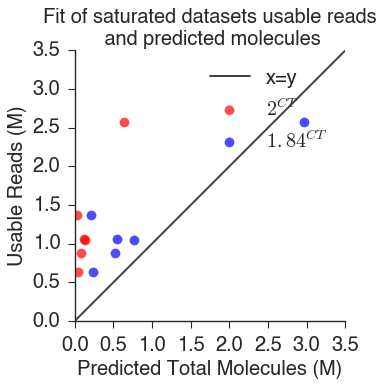

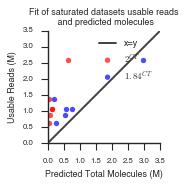

In [24]:
num_rows = 1
num_cols = 1

saturated_datasets = total_usable[total_usable.fraction_usable < .10]
linregress = scipy.stats.linregress(saturated_datasets.predicted_usable_molecules_tight,
                                    saturated_datasets[unique])
r2 = np.power(linregress.rvalue, 2)

with dataviz.Figure(os.path.join(img_dir, "estimated_reads_to_ect_concentration_presentation.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(saturated_datasets['predicted_usable_molecules_concentration'], saturated_datasets[unique],
               s=70, alpha=.7, color='r', label="$2^{CT}$")
    ax.scatter(saturated_datasets['predicted_usable_molecules_tight_concentration'], 
               saturated_datasets[unique], 
               alpha=.7, color="b", s=70,
               label="${:.3}^{{CT}}$".format(tight_pcr))
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.set_xlabel("Predicted Total Molecules (M)", fontsize=18)
    ax.set_ylabel("Usable Reads (M)", fontsize=18)
    ax.set_title("Fit of saturated datasets usable reads\n and predicted molecules", fontsize=18)
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlim(0,)
    ax.set_ylim(0,)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="x=y")
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend(fontsize=18)
    sns.despine(ax=ax)
    
with dataviz.Figure(os.path.join(img_dir, "estimated_reads_to_ect_concentration.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(saturated_datasets['predicted_usable_molecules_concentration'], 
               saturated_datasets[unique], alpha=.7, color='r', label="$2^{CT}$")
    ax.scatter(saturated_datasets['predicted_usable_molecules_tight_concentration'], 
               saturated_datasets[unique], 
               alpha=.7, color="b", 
               label="${:.3}^{{CT}}$".format(tight_pcr))
    [tick.set_fontsize(7) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(7) for tick in ax.get_yticklabels()]

    ax.set_xlabel("Predicted Total Molecules (M)", fontsize=8)
    ax.set_ylabel("Usable Reads (M)", fontsize=8)
    ax.set_title("Fit of saturated datasets usable reads\n and predicted molecules", fontsize=8)
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_xlim(0,)
    ax.set_ylim(0,)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="x=y")
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.legend(fontsize=8)
    sns.despine(ax=ax)

In [25]:
adjust_ect_tight = functools.partial(adjust_ect, new_pcr=tight_pcr)
eCT_and_usable['adjusted_ect_concentration'] = eCT_and_usable.apply(adjust_ect_tight, axis=1)
total_usable = eCT_and_usable.xs(1.0, level="fraction")
total_usable['fraction_usable'] = total_usable.unique / total_usable.uncollapsed

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now that I have my actual pcr effecency estimate I can now go ahead and re-estimate eCT for everything, I use the eCT to estimate initial molecues because it makes things easier, keeps people from having to do too many calculations

Really plotting 3 things, CORRECTED estimation line, with corrected eCT and same or new model fitting 90% reads? Probably new model 

Using the initial eCT value to estimate the new PCR cycle is circular, I think I want to use the concentration, to back calculate.  

# Plot re-estimate eCT to usable read number

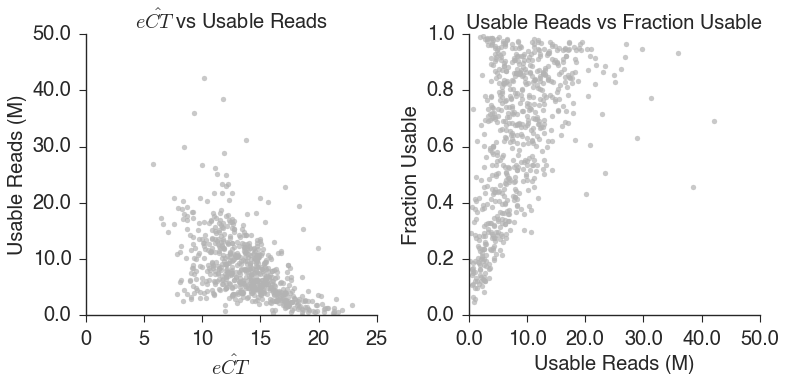

In [26]:
num_cols = 2
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_presentation.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    ax.scatter(total_usable.adjusted_ect_concentration, total_usable[unique], alpha=.7, color=".7")
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Usable Reads (M)", fontsize=18)
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_title("$\hat{eCT}$ vs Usable Reads", fontsize=18)
    sns.despine(ax=ax)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    ax.scatter(total_usable[unique], total_usable['fraction_usable'], alpha=.7, color=".7")
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xlabel("Usable Reads (M)", fontsize=18)
    ax.set_ylabel("Fraction Usable", fontsize=18)
    ax.set_title("Usable Reads vs Fraction Usable", fontsize=18)
    sns.despine(ax=ax)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]
    ax.set_xlim(0)
    ax.set_ylim(0, 1)

The point I want to make here is that the eCT is correlated to the number of usable reads, but due to sequencing depth issues usable reads is not always the total number of usable reads in a dataset

# Correlate eCT to % usable?

eCT values for all eCLIP datasets
/home/elvannostrand/data/ENCODE/project_stuff/ENCODE_CLIP_alldata_20161206.txt
col 24 is rep1 eCT, col 34 is rep2 eCT, col44 is input eCT


In [27]:
fraction_usable = counts_list.xs(1.0,level="fraction")
fraction_usable = fraction_usable[unique] / fraction_usable.uncollapsed
fraction_usable = fraction_usable.unstack().unstack()
fraction_usable['uID'] = fraction_usable.index.get_level_values(level=0)
fraction_usable = pd.merge(fraction_usable, eCT_data, left_on="uID", right_index=True)
fraction_usable.columns = ["_".join(items) if type(items) is tuple else items for items in fraction_usable.columns]

In [28]:
# sns.lmplot(y="1_01", x="eCT_rep1", data=fraction_usable, fit_reg=True)
# sns.lmplot(y="1_02", x="eCT_rep1", data=fraction_usable, fit_reg=True)
# sns.lmplot(y="2_01", x="eCT_rep2", data=fraction_usable, fit_reg=True)
# sns.lmplot(y="2_02", x="eCT_rep2", data=fraction_usable, fit_reg=True)

There is a strong correlation between fraction usable and eCT, can make the rest of the figures later.  This doesn't get at the question, how deeply CAN I sequence, but it does tell you library complexity is primary decided by eCT value, how can I use this with my saturation curves? 

In [29]:
# with dataviz.Figure(os.path.join(img_dir, "foo.svg".format(plot_num)), figsize=(4 * 2, 4 * 1)) as fig:
#     ax = fig.add_subplot(1,2,1)
#     ax.plot(row.uncollapsed, row[unique], color=colors[color], label="_".join(name), linewidth=4, alpha=.7)
#     ax = fig.add_subplot(1,2,2)
#     ax.plot(np.log10(row.uncollapsed), row[unique], color=colors[color], label="_".join(name), linewidth=4, alpha=.7)


Couple ways to do this, fit each line individually then see how the individual fits correlate to the eCT, 
Group all datasets by eCT and train model on that

In [30]:
counts_list['uID'] = counts_list.index.get_level_values(level=0)

In [31]:
# reg = sklearn.linear_model.LinearRegression()
# result = reg.fit(eCT_and_usable[['log_uncollapsed', 'eCT']], eCT_and_usable[unique])

In [32]:
eCT_and_usable.to_csv("ect_estimate_usable_reads.csv")

# For regression make sure Input Reads, eCT and Usable reads are linearly related

In [33]:
eCT_and_usable_filtered = total_usable[total_usable.fraction_usable < .90]

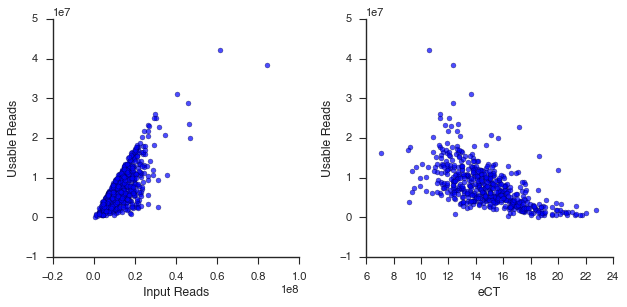

In [34]:
#If I filter the reads to some smaller number of fraction usable what happens?
num_rows = 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(1,2,1)
    ax.scatter(eCT_and_usable_filtered.uncollapsed, eCT_and_usable_filtered[unique], alpha=.7)
    ax.set_xlabel("Input Reads")
    ax.set_ylabel("Usable Reads")
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(1,2,2)
    ax.scatter(eCT_and_usable_filtered.eCT, eCT_and_usable_filtered[unique], alpha=.7)
    ax.set_xlabel("eCT")
    ax.set_ylabel("Usable Reads")
    sns.despine(ax=ax)

So linear regression on eCT and Input reads won't work well, they aren't linerally related.

Usable reads sucks as a metric because its not invariant, I need some sort of invariant metric for each dataset, something that describes the curve of the line?  

# Try tying eCT to polynomial fit for each line, see how that goes

In [35]:
result = defaultdict(dict)
for rbp_name, rbp_row in eCT_and_usable.groupby(level=["RBP_ID", "RBP", "bio_rep"]):
    
    z = np.polyfit(x=rbp_row.uncollapsed, y=rbp_row[unique], deg=2)
    poly_2 = z[0]
    poly_1 = z[1]
    poly_0 = z[2]
    result[rbp_name] = {'poly_2': poly_2, 
                        'poly_1': poly_1, 
                        'poly_0': poly_0, 
                        "eCT": rbp_row.eCT.values[0]}

In [36]:
eCT_polynomial_fit = pd.DataFrame(result).T

So this works pretty well, but there are too many variables to properly make a model, going to try different fitting algoritms

# Functions for curve fitting

In [37]:
#I reversed the log rule logb(x) = log(x)/ log(b) to be b = e(log(x)/ logb(x)) where logb(x) = uniqueed value and x = real reads

def log_function (x, base): 
    return np.log(x) / np.log(base)

def fit_log(uncollapsed, unique):
    z = scipy.optimize.curve_fit(f=log_function, 
                                 xdata=uncollapsed, 
                                 ydata=unique,
                                 method="dogbox", 
                                 bounds=(0,100))
    base = z[0][0]
    return base

def tanh_function (x, scale, slope): 
    return scale * np.tanh(x * slope)

def tanh_fit(uncollapsed, unique):
    #I get these from math of trying to solve for a in the equation
    # y = a tanh(xb)
    #where y is number of duplicate removed reads, x is the number of input reads and a and b are free paramaters 
    slope_estimate = 1. / (uncollapsed[1.0] * 2)
    scale_estimate = unique[1.0] / np.tanh(uncollapsed[1.0] * slope_estimate)
    p0 = [scale_estimate, slope_estimate]
    z = scipy.optimize.curve_fit(f=tanh_function, 
                                 xdata=uncollapsed, 
                                 ydata=unique, 
                                 method="trf", 
                                 bounds=(0, [scale_estimate * 3, 5]),
                                 p0=p0)
    scale, slope = z[0]
    return scale, slope

def squrt_function (x, scale, slope): 
    return scale * np.sqrt(x * slope)

def squrt_fit(uncollapsed, unique):
    slope_estimate = 1/10.
    scale_estimate = unique[1.0] / np.sqrt(uncollapsed[1.0] * slope_estimate)
    p0 = [scale_estimate, slope_estimate]
    z = scipy.optimize.curve_fit(f=squrt_function, 
                                 xdata=uncollapsed, 
                                 ydata=unique, 
                                 method="trf", 
                                 bounds=(0, [scale_estimate * 3, 5]),
                                 p0=p0)
    scale, slope = z[0] 
    
    return scale, slope

# #Fit using the newly estimated max reads a a better estimate of the total number of max reads
# def tanh_max_reads_loose_fit(uncollapsed, unique, max_reads):
#     #I get these from math of trying to solve for a in the equation
#     # y = a tanh(xb)
#     #where y is number of duplicate removed reads, x is the number of input reads and a and b are free paramaters 
#     slope_estimate = 1. / (uncollapsed[1.0] * 2)
#     scale_estimate = max_reads[1.0]
    
#     p0 = [scale_estimate, slope_estimate]
#     z = scipy.optimize.curve_fit(f=tanh_function, 
#                                  xdata=uncollapsed, 
#                                  ydata=unique, 
#                                  method="trf", 
#                                  bounds=(0, [scale_estimate * 3, 5]),
#                                  p0=p0)
#     scale, slope = z[0]
#     return scale, slope


def tanh_loc_swapped_function (x, slope, scale): 
    return scale * np.tanh(x * slope)

#Fit using max input reads as ground truth for max reads
def tanh_max_reads_fit(uncollapsed, unique, max_reads):
    #I get these from math of trying to solve for a in the equation
    # y = a tanh(xb)
    #where y is number of duplicate removed reads, x is the number of input reads and a and b are free paramaters 
    partal_tanh = functools.partial(tanh_loc_swapped_function, scale=max_reads[1.0])
    slope_estimate = 1. / (uncollapsed[1.0] * 2)
    p0 = slope_estimate
    z = scipy.optimize.curve_fit(f=partal_tanh, 
                                 xdata=uncollapsed, 
                                 ydata=unique, 
                                 method="lm", 
                                 #bounds=(0, 5),
                                 p0=p0)
    slope = z[0]
    return max_reads[1.0], slope[0]

# Fit all functions to all datasets and plot the best fits

In [38]:
def tanh_fit_row(rbp_grp):
    scale, slope = tanh_fit(rbp_grp.uncollapsed, rbp_grp[unique])
    return pd.Series({"scale_tanh": scale, "slope_tanh": slope})

def tanh_fit_r2(rbp_grp):
    index = rbp_grp.index[0][:-1]
    model = total_usable.ix[index]
    return r2_score(rbp_grp[unique], tanh_function(rbp_grp.uncollapsed, model['scale_tanh'], model['slope_tanh']))

def squrt_fit_row(rbp_grp):
    scale, slope = squrt_fit(rbp_grp.uncollapsed, rbp_grp[unique])
    return pd.Series({"scale_sqrt": scale, "slope_sqrt": slope})

def squrt_fit_r2(rbp_grp):
    index = rbp_grp.index[0][:-1]
    model = total_usable.ix[index]
    return r2_score(rbp_grp[unique], squrt_function(rbp_grp.uncollapsed, model['scale_sqrt'], model['slope_sqrt']))

def log_fit_row(rbp_grp):
    base = fit_log(rbp_grp.uncollapsed, rbp_grp[unique])
    return pd.Series({"base_log": base})

def log_fit_r2(rbp_grp):
    index = rbp_grp.index[0][:-1]
    model = total_usable.ix[index]
    return r2_score(rbp_grp[unique], log_function(rbp_grp.uncollapsed, model['base_log']))

def tanh_read_est_fit_row(rbp_grp):
    scale, slope = tanh_max_reads_fit(rbp_grp.uncollapsed, rbp_grp[unique], rbp_grp.predicted_usable_molecules_tight_concentration)
    return pd.Series({"tanh_read_est_scale": scale, "tanh_read_est_slope": slope})

def tanh_read_est_fit_r2(rbp_grp):
    index = rbp_grp.index[0][:-1]
    model = total_usable.ix[index]
    return r2_score(rbp_grp[unique], tanh_function(rbp_grp.uncollapsed, model['tanh_read_est_scale'], model['tanh_read_est_slope']))

In [39]:
#total_usable = eCT_and_usable.xs(1.0, level="fraction")

In [40]:
grp = eCT_and_usable.groupby(level=['RBP_ID', "RBP", "bio_rep"], sort=False)

total_usable = pd.concat([total_usable, grp.apply(tanh_fit_row)], axis=1)
total_usable['tanh_fit_r2'] = grp.apply(tanh_fit_r2)

total_usable = pd.concat([total_usable, grp.apply(squrt_fit_row)], axis=1)
total_usable['sqrt_fit_r2'] = grp.apply(squrt_fit_r2)

total_usable = pd.concat([total_usable, grp.apply(log_fit_row)], axis=1)
total_usable['log_fit_r2'] = grp.apply(log_fit_r2)

total_usable = pd.concat([total_usable, grp.apply(tanh_read_est_fit_row)], axis=1)
total_usable['tanh_read_est_fit_r2'] = grp.apply(tanh_read_est_fit_r2)

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:1256: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
/home/gpratt/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Plot RBFOX2 to show initial goodness of fit

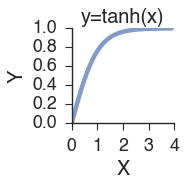

In [41]:
x = np.arange(0, 4, .1)
y = np.tanh(x)

with dataviz.Figure(os.path.join(img_dir, "tanh.svg".format(plot_num)), figsize=(2.5 * 1, 2.5 * 1)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.plot(x, y, label="y=tanh(x)", linewidth=4, alpha=.7)

    ax.set_title("y=tanh(x)", fontsize=18)
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.set_xlabel("X", fontsize=18)
    ax.set_ylabel("Y", fontsize=18)
    ax.set_xticks(np.arange(0,5))
    [tick.set_fontsize(16) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(16) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

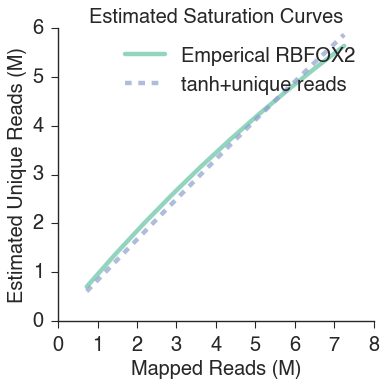

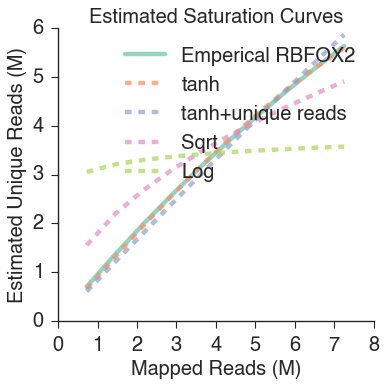

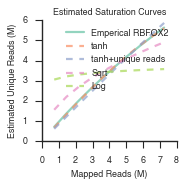

In [42]:
rbp = ("204", "RBFOX2", "01")
rbp_row = eCT_and_usable.ix[rbp]    
model = total_usable.ix[rbp]
colors = sns.color_palette("Set2", 5)

with dataviz.Figure(os.path.join(img_dir, "function_fitting_presentation_v2.svg".format(plot_num)), figsize=(5 * 1, 5 * 1)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.plot(rbp_row.uncollapsed, rbp_row[unique], color=colors[0], label="Emperical RBFOX2", linewidth=4, alpha=.7)
    ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, model.tanh_read_est_scale, model.tanh_read_est_slope), 
            color=colors[2], label="tanh+unique reads", linewidth=4, alpha=.7, linestyle="--")

    ax.set_title("Estimated Saturation Curves", fontsize=18)
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Mapped Reads (M)", fontsize=18)
    ax.set_ylabel("Estimated Unique Reads (M)".format(" ".join(rbp_name)), fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.legend(fontsize=18)
    sns.despine(ax=ax)
    
with dataviz.Figure(os.path.join(img_dir, "function_fitting_presentation.svg".format(plot_num)), figsize=(5 * 1, 5 * 1)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.plot(rbp_row.uncollapsed, rbp_row[unique], color=colors[0], label="Emperical RBFOX2", linewidth=4, alpha=.7)
    ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, model.scale_tanh, model.slope_tanh), 
            color=colors[1], label="tanh", linewidth=4, alpha=.7, linestyle="--")
    ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, model.tanh_read_est_scale, model.tanh_read_est_slope), 
            color=colors[2], label="tanh+unique reads", linewidth=4, alpha=.7, linestyle="--")

    ax.plot(rbp_row.uncollapsed, squrt_function(rbp_row.uncollapsed, model.scale_sqrt, model.slope_sqrt), 
            color=colors[3], label="Sqrt", linewidth=4, alpha=.7, linestyle="--")
    ax.plot(rbp_row.uncollapsed, log_function(rbp_row.uncollapsed, model.base_log), 
            color=colors[4], label="Log", linewidth=4, alpha=.7, linestyle="--")

    ax.set_title("Estimated Saturation Curves", fontsize=18)
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Mapped Reads (M)", fontsize=18)
    ax.set_ylabel("Estimated Unique Reads (M)".format(" ".join(rbp_name)), fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.legend(fontsize=18)
    sns.despine(ax=ax)
    
with dataviz.Figure(os.path.join(img_dir, "function_fitting.svg".format(plot_num)), figsize=(2.5 * 1, 2.5 * 1)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.plot(rbp_row.uncollapsed, rbp_row[unique], color=colors[0], label="Emperical RBFOX2", linewidth=2, alpha=.7)
    ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, model.scale_tanh, model.slope_tanh), 
            color=colors[1], label="tanh", linewidth=2, alpha=.7, linestyle="--")
    ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, model.tanh_read_est_scale, model.tanh_read_est_slope), 
            color=colors[2], label="tanh+unique reads", linewidth=2, alpha=.7, linestyle="--")

    ax.plot(rbp_row.uncollapsed, squrt_function(rbp_row.uncollapsed, model.scale_sqrt, model.slope_sqrt), 
            color=colors[3], label="Sqrt", linewidth=2, alpha=.7, linestyle="--")
    ax.plot(rbp_row.uncollapsed, log_function(rbp_row.uncollapsed, model.base_log), 
            color=colors[4], label="Log", linewidth=2, alpha=.7, linestyle="--")

    ax.set_title("Estimated Saturation Curves", fontsize=8)
    ax.set_xlim(0, )
    ax.set_ybound(0, )
    ax.xaxis.set_major_formatter(xfmt_int)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_xlabel("Mapped Reads (M)", fontsize=8)
    ax.set_ylabel("Estimated Unique Reads (M)".format(" ".join(rbp_name)), fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    ax.legend(fontsize=8)
    sns.despine(ax=ax)

In [43]:
print model.tanh_fit_r2, model.sqrt_fit_r2, model.log_fit_r2, model.tanh_read_est_fit_r2

0.999639972647 0.871708373667 0.182013259891 0.991510905631


Conclusion: It looks like tanh fits the best of everything, assuming an x and y intercept of 0.  The unique molecues estimate fits almost as well with the added benefit of having my model more paramartized

# Plot all fits for all functions

In [44]:
r2_df = pd.DataFrame(pd.concat({"tanh": pd.Series(total_usable.tanh_fit_r2, name="r2"), 
                                "tanh+unique reads": pd.Series(total_usable.tanh_read_est_fit_r2, name="r2"),
                                "sqrt": pd.Series(total_usable.sqrt_fit_r2, name="r2"),
                                "log": pd.Series(total_usable.log_fit_r2, name="r2"),
                               }))
r2_df['function'] = r2_df.index.get_level_values(level=0)

In [45]:
r2_df.groupby("function").mean()

r2
function                   
log                0.208665
sqrt               0.888064
tanh               0.985823
tanh+unique reads  0.231219

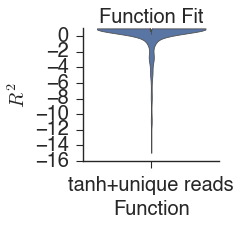

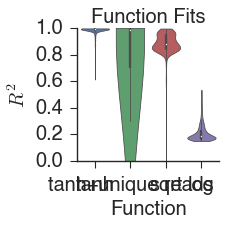

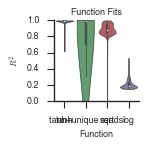

In [46]:
#this shows that the fit of each curve is very good, but there is too much variance 
#between each curve to propery fit a general model
num_cols = 1
num_rows = 1

order = ['tanh+unique reads']
with dataviz.Figure(os.path.join(img_dir, "function_r2_presentation_v2.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(y="r2", x="function", data=r2_df, 
                   ax=ax, orient='v', order=order, bw="silverman", scale="count",
                   inner="box",
                   cut=0, linewidth=.7)
    ax.set_ylim(-16, 1)
    ax.set_ylabel("$R^2$", fontsize=18) 
    ax.set_xlabel("Function", fontsize=18)
    ax.set_title("Function Fit", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)
    

order = ['tanh', 'tanh+unique reads', 'sqrt', 'log']
with dataviz.Figure(os.path.join(img_dir, "function_r2_presentation.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(y="r2", x="function", data=r2_df, 
                   ax=ax, orient='v', order=order, bw="silverman", scale="count",
                   inner="box",
                   cut=0, linewidth=.7)
    ax.set_ylim(0, 1)
    ax.set_ylabel("$R^2$", fontsize=18) 
    ax.set_xlabel("Function", fontsize=18)
    ax.set_title("Function Fits", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)
    
with dataviz.Figure(os.path.join(img_dir, "function_r2.svg"), figsize=(2 * num_cols, 2 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(y="r2", x="function", data=r2_df, 
                   ax=ax, orient='v', order=order, bw="silverman", scale="count",
                   inner="box",
                   cut=0, linewidth=.7)
    ax.set_ylim(0, 1)
    ax.set_ylabel("$R^2$", fontsize=8) 
    ax.set_xlabel("Function", fontsize=8)
    ax.set_title("Function Fits", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

Overall the tanh with the estimated read number actually fits poorly, this is almost entirely because of RBPs that have a low estimated concentration and a high estimated PCR cycle out perform their expected read numbers.  (See plot below).  I don't quite know what to do about that, other than to say screw it, we've still got a more sane model than in the past. 

In [47]:
bad_fit = total_usable[total_usable.tanh_read_est_fit_r2 < .2]
fine_fit = total_usable[total_usable.tanh_read_est_fit_r2 >= .2]

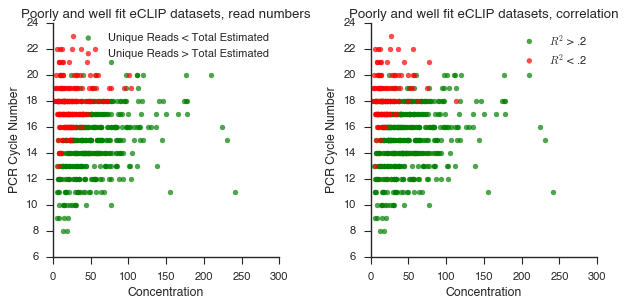

In [48]:

num_cols = 2
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "function_r2.svg"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows, num_cols, 1)
    
    bad_fit = total_usable[total_usable.predicted_usable_molecules_tight_concentration < total_usable[unique]]
    fine_fit = total_usable[total_usable.predicted_usable_molecules_tight_concentration >= total_usable[unique]]
    
    ax.scatter(fine_fit.concentration, fine_fit.cycle_num, color='g', alpha=.7, label="Unique Reads < Total Estimated")
    ax.scatter(bad_fit.concentration, bad_fit.cycle_num, color='r', alpha=.7, label="Unique Reads > Total Estimated")
    ax.set_xlabel("Concentration")
    ax.set_ylabel("PCR Cycle Number")
    ax.set_title("Poorly and well fit eCLIP datasets, read numbers")
    ax.set_xlim(0)
    ax.set_ylim(6)
    sns.despine(ax=ax)
    ax.legend()
    
    ax = fig.add_subplot(num_rows, num_cols, 2)
    
    bad_fit = total_usable[total_usable.tanh_read_est_fit_r2 < .2]
    fine_fit = total_usable[total_usable.tanh_read_est_fit_r2 >= .2]    
    
    ax.scatter(fine_fit.concentration, fine_fit.cycle_num, color='g', alpha=.7, label="$R^2$ > .2")
    ax.scatter(bad_fit.concentration, bad_fit.cycle_num, color='r', alpha=.7, label="$R^2$ < .2")
    ax.set_xlabel("Concentration")
    ax.set_ylabel("PCR Cycle Number")
    ax.set_title("Poorly and well fit eCLIP datasets, correlation")
    ax.set_xlim(0)
    ax.set_ylim(6)
    sns.despine(ax=ax)
    ax.legend()


# Plot out how well the original hyperbolic tangent might fit regression models

In [49]:
total_usable['scaled_slope'] = total_usable.slope_tanh * 1000000
smaller_slope_results = total_usable[total_usable.scaled_slope < 1]

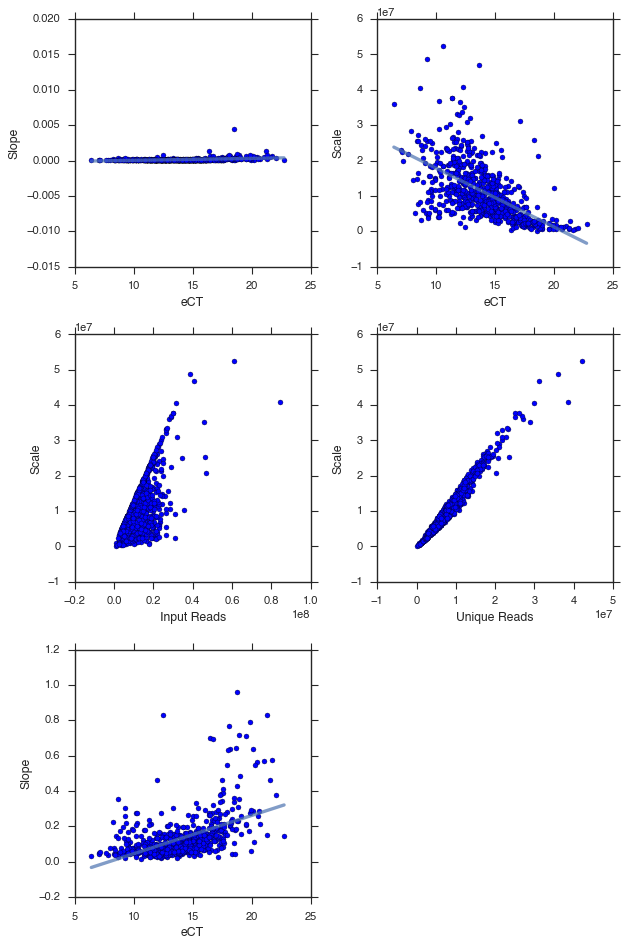

In [50]:
num_rows = 3
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "tanh_correlated_to_ect.png"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(total_usable.eCT, total_usable.slope_tanh * 1000)
    
    ect_vs_slope_reg = scipy.stats.linregress(total_usable.eCT, total_usable.slope_tanh * 1000)
    fit = np.poly1d([ect_vs_slope_reg.slope, ect_vs_slope_reg.intercept])
    ax.plot([min(total_usable.eCT), max(total_usable.eCT)],
            [fit(min(total_usable.eCT)), fit(max(total_usable.eCT))],
           linewidth=3, alpha=.7)
    #ax.text(20, 70000000, "$R^2$:{:.2}".format(np.power(linregress.rvalue, 2)), fontsize=10)

    ax.set_xlabel("eCT")
    ax.set_ylabel("Slope")

    ax = fig.add_subplot(num_rows,num_cols,2)
    ax.scatter(total_usable.eCT, total_usable.scale_tanh)
    
    ect_vs_scale_reg = scipy.stats.linregress(total_usable.eCT, total_usable.scale_tanh )
    fit = np.poly1d([ect_vs_scale_reg.slope, ect_vs_scale_reg.intercept])
    ax.plot([min(total_usable.eCT), max(total_usable.eCT)],
            [fit(min(total_usable.eCT)), fit(max(total_usable.eCT))],
           linewidth=3, alpha=.7)
    ax.set_xlabel("eCT")
    ax.set_ylabel("Scale")
    
    ax = fig.add_subplot(num_rows,num_cols,3)
    ax.scatter(total_usable.uncollapsed, total_usable.scale_tanh)
    
    input_reads_vs_scale_reg = scipy.stats.linregress(total_usable.uncollapsed, total_usable.scale_tanh )
    fit = np.poly1d([input_reads_vs_scale_reg.slope, input_reads_vs_scale_reg.intercept])
    ax.plot([min(total_usable.eCT), max(total_usable.eCT)],
            [fit(min(total_usable.eCT)), fit(max(total_usable.eCT))],
           linewidth=3, alpha=.7)
    ax.set_xlabel("Input Reads")
    ax.set_ylabel("Scale")
    
    ax = fig.add_subplot(num_rows,num_cols,4)
    ax.scatter(total_usable[unique], total_usable.scale_tanh)
    
    unique_reads_vs_scale_reg = scipy.stats.linregress(total_usable[unique], total_usable.scale_tanh )
    fit = np.poly1d([unique_reads_vs_scale_reg.slope, unique_reads_vs_scale_reg.intercept])
    ax.plot([min(total_usable.eCT), max(total_usable.eCT)],
            [fit(min(total_usable.eCT)), fit(max(total_usable.eCT))],
           linewidth=3, alpha=.7)
    ax.set_xlabel("Unique Reads")
    ax.set_ylabel("Scale")

    ax = fig.add_subplot(num_rows,num_cols,5)
    ax.scatter(smaller_slope_results.eCT, smaller_slope_results.scaled_slope)
    
    ect_vs_scaled_slope_reg = scipy.stats.linregress(smaller_slope_results.eCT, smaller_slope_results.scaled_slope )
    fit = np.poly1d([ect_vs_scaled_slope_reg.slope, ect_vs_scaled_slope_reg.intercept])
    ax.plot([min(total_usable.eCT), max(total_usable.eCT)],
            [fit(min(total_usable.eCT)), fit(max(total_usable.eCT))],
           linewidth=3, alpha=.7)

    ax.set_xlabel("eCT")
    ax.set_ylabel("Slope")

In [51]:
print unique_reads_vs_scale_reg
print ect_vs_slope_reg
print ect_vs_scale_reg
print input_reads_vs_scale_reg

LinregressResult(slope=1.3992548797181061, intercept=-737678.079566909, rvalue=0.98353127044036404, pvalue=0.0, stderr=0.010070115099925319)
LinregressResult(slope=2.7210301337182792e-05, intercept=-0.00023989646000565162, rvalue=0.35457782876257532, pvalue=8.2724390249632993e-21, stderr=2.8101008004079962e-06)
LinregressResult(slope=-1663229.312999621, intercept=34456750.219888829, rvalue=-0.58497687802191012, pvalue=2.6624826096482062e-61, stderr=90310.291536194767)
LinregressResult(slope=0.68210011884157395, intercept=1815479.1528101414, rvalue=0.64328041360698096, pvalue=1.1638811991135245e-77, stderr=0.031793864303298759)


Turns out the eCT doesn't really correlate with the slope, I kind of expected this, need to incorporate the repetitive elements to figure this one out.  

# How well can I predict results from simple linear model?

In [52]:
scale_regressor = scipy.stats.linregress(total_usable.eCT, total_usable.scale_tanh)
slope_regressor = scipy.stats.linregress(total_usable.eCT, total_usable.slope_tanh)

print scale_regressor
print slope_regressor

LinregressResult(slope=-1663229.312999621, intercept=34456750.219888829, rvalue=-0.58497687802191012, pvalue=2.6624826096482062e-61, stderr=90310.291536194767)
LinregressResult(slope=2.7210301337182786e-08, intercept=-2.398964600056515e-07, rvalue=0.35457782876257526, pvalue=8.2724390249634784e-21, stderr=2.8101008004079964e-09)


In [53]:
fitted_result = []

for name, row in total_usable.iterrows():    
    scale = scale_regressor.intercept + scale_regressor.slope * row.eCT
    slope = slope_regressor.intercept + slope_regressor.slope * row.eCT
    
    fitted_result.append(tanh_function(row.uncollapsed, scale, slope ))
total_usable['fitted_result'] = fitted_result

print "R2", r2_score(total_usable[unique], total_usable.fitted_result)

R2 -0.0511148532386


Linear Model isn't great, don't think I can publish something that has an R2 of -0.3

The main question is what do I report.  

2 things.  The best and worst case slopes, but also given those slopes the number of reads you need to sequence to achieve 95% library saturation? 

# What is the number of reads you need to sequence 90% of molecules?
Up till now I've been using the unparamaterized tanh data, here I'll switched to the paramaterized version

to get max reads

$1 = \tanh(slope * input)$

$\frac{atanh(1)}{slope} = input$ 


In [54]:
def get_x_precent_usable(row, percent=90):
    
    """
    For each row gets the total number of input reads required to recover ~90% of usable reads
    """
        
    output_read_max = row.tanh_read_est_scale
    
    percent_usable = output_read_max * percent
    reads_required = get_x_precent_usable(row, percent_usable)
 
    return reads_required

def get_x_usable_reads(row, min_reads_required=3000000):
    
    """
    Gets the minimum number of input reads required to meet a minimum threshold of usable reads
    """
    
    read_increments = 10000
    input_read_estimate = math.atanh(.9999) / row.tanh_read_est_slope
    input_read_array = np.arange(0, input_read_estimate, read_increments)

    threshold_reads = tanh_function(input_read_array, row.tanh_read_est_scale, row.tanh_read_est_slope)
    where_counts = np.where(threshold_reads > min_reads_required)[0]
    if len(where_counts) == 0:
        reads_required = threshold_reads[-1]
    else:
        reads_required = where_counts[0] * read_increments
    
    return reads_required

In [55]:
total_usable['90_percent_of_total_reads'] = total_usable.apply(get_x_precent_usable, axis=1)
total_usable['min_reads_required'] = total_usable.apply(get_x_usable_reads, axis=1)

RuntimeError: ('maximum recursion depth exceeded in cmp', u'occurred at index (202, PTBP1, 01)')

In [ ]:
#This is an odd fit because I'm using the fitted data, which is pretty dependent on input reads / quantification estimates
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "estimated_90_percent_reads_to_ect_presentation.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(total_usable.adjusted_ect_concentration, total_usable['90_percent_of_total_reads'], alpha=.7, color=".7")
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_ylabel("Input Reads (M)", fontsize=18)
    ax.set_title("Input reads to detect\n90% of total molecules", fontsize=18)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_ylim(0,)
    ax.set_xlim(5)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)
    
#This is an odd fit because I'm using the fitted data, which is pretty dependent on input reads / quantification estimates
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "estimated_90_percent_reads_to_ect.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(total_usable.adjusted_ect_concentration, 
               total_usable['90_percent_of_total_reads'], 
               alpha=.7, color=".7", s=2)
    ax.set_xlabel("$\hat{eCT}$", fontsize=8)
    ax.set_ylabel("Input Reads (M)", fontsize=8)
    ax.set_title("Input reads to detect\n90% of total molecules", fontsize=8)
    ax.yaxis.set_major_formatter(xfmt_int)
    ax.set_ylim(0,)
    ax.set_xlim(5)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

In [ ]:
linregress = scipy.stats.linregress(total_usable.eCT, np.log2(total_usable['90_percent_of_total_reads']))
print linregress

I think this fit is just a modified version of my calculation down below, if I should probably just try to generally fit a regression to this, with the equation for doubling guiding me?  I'm getting tired, should probaly come back to this tomorrow...

In [ ]:
total_usable['min_reads_required_loss'] = total_usable.min_reads_required / .73
tanh_min_threshold = total_usable[total_usable.min_reads_required > 3000000]

In [ ]:
def grouper(x):
    return math.floor(total_usable.ix[x].eCT)

In [ ]:
tanh_results_grouped = total_usable.groupby(by=grouper)


In [ ]:
for x in tanh_results_grouped.mean()['min_reads_required_loss']:
    print x

In [ ]:

num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "estimated_count_reads_to_ect_presentation.svg"), figsize=(5 * num_cols, 5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(tanh_min_threshold.adjusted_ect_concentration, tanh_min_threshold['min_reads_required_loss'], alpha=.7, color=".7")
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_ylabel("Input Reads (M)", fontsize=18)
    ax.set_title("Input reads to detect\n3M total molecules", fontsize=18)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylim(0,)
    sns.despine(ax=ax)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "estimated_count_reads_to_ect.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:

    ax = fig.add_subplot(num_rows,num_cols,1)
    ax.scatter(tanh_min_threshold.adjusted_ect_concentration, 
               tanh_min_threshold['min_reads_required_loss'], 
               alpha=.7, color=".7", s=2)
    ax.set_xlabel("$\hat{eCT}$", fontsize=8)
    ax.set_ylabel("Input Reads (M)", fontsize=8)
    ax.set_title("Input reads to detect\n3M total molecules", fontsize=8)
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylim(0,)
    sns.despine(ax=ax)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


This tells me the number of reads I need to sequence to get 3M usable reads. This is the plot that summarizes the guidelines for how deeply to sequence

molecules * 2^eCT/ = input reads 
robust linear regression 

# Save Asymptoic Analysis
This is old, but keeping it around just in cases

In [ ]:
tanh_results_grouped = total_usable.groupby(by=grouper)

with open(os.path.join(img_dir, "reads_required.csv"), 'w') as out_file:
    out_file.write(",".join(["eCT", "best_case_max_reads", "worst_case_max_reads", "best_case_90%_reads", "worst_case_90%_reads"]) + "\n")
    for name, df in tanh_results_grouped:
        best_case = df.ix[0]
        worst_case = df.ix[-1]

        out_file.write(",".join(map(str, [name, math.floor(best_case.scale_tanh), math.floor(worst_case.scale_tanh), best_case['90_percent_of_total_reads'], worst_case['90_percent_of_total_reads']])) + "\n")

# How well does my model work compared to the real data?

In [ ]:
eCT_estimate = np.arange(5, 26)
total_molecules = calc_initial_molecues_estimate(eCT_estimate, tight_pcr)

In [ ]:
num_cols = 1
num_rows = 1

saturated = total_usable[total_usable.fraction_usable < .60]
not_saturated = total_usable[total_usable.fraction_usable >= .60]

with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_estimate_presentation_v0.svg"), figsize=(5.0 * num_cols, 5.0 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(total_usable.eCT, 
               total_usable[unique], alpha=.4, color=".7")
    
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Usable Reads (M)", fontsize=18)
    ax.set_xlabel("eCT", fontsize=18)
    ax.set_title("eCT vs Unique Molecules", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.set_ylim(0, 100000000)
    ax.set_xlim(0,25)
    sns.despine(ax=ax)
    

In [ ]:

num_cols = 1
num_rows = 1

saturated = total_usable[total_usable.fraction_usable < .60]
not_saturated = total_usable[total_usable.fraction_usable >= .60]

with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_estimate_presentation_v1.svg"), figsize=(5.0 * num_cols, 5.0 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(total_usable.adjusted_ect_concentration, 
               total_usable[unique], alpha=.4, color=".7")
    
    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Unique Molecules (M)", fontsize=18)
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_title("$\hat{eCT}$ vs Unique Molecules", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.set_ylim(0, 10000000000)
    ax.set_xlim(0,25)
    sns.despine(ax=ax)
    

num_cols = 1
num_rows = 1

saturated = total_usable[total_usable.fraction_usable < .60]
not_saturated = total_usable[total_usable.fraction_usable >= .60]

with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_estimate_presentation_v2.svg"), figsize=(5.0 * num_cols, 5.0 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(total_usable.adjusted_ect_concentration, 
               total_usable[unique], alpha=.4, color=".7")
    ax.plot(eCT_estimate, total_molecules, 
            alpha=.7, color=".2", linestyle="--", linewidth=3, label="Estimated Unique Molecules")

    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Unique Molecules (M)", fontsize=18)
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_title("$\hat{eCT}$ vs Unique Molecules", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.legend(loc=0, fontsize=18)
    ax.set_ylim(0, 10000000000)
    ax.set_xlim(0,25)

    sns.despine(ax=ax)
    


num_cols = 1
num_rows = 1

saturated = total_usable[total_usable.fraction_usable < .60]
not_saturated = total_usable[total_usable.fraction_usable >= .60]

with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_estimate_presentation_v3.svg"), figsize=(5.0 * num_cols, 5.0 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(saturated.adjusted_ect_concentration, 
               saturated[unique], alpha=.4, color="r", label="Saturated")
    ax.scatter(not_saturated.adjusted_ect_concentration, 
               not_saturated[unique], alpha=.4, color="g", label="Not Saturated")
    ax.plot(eCT_estimate, total_molecules, 
            alpha=.7, color=".2", linestyle="--", linewidth=3, label="Estimated Unique Molecules")

    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Unique Molecules (M)", fontsize=18)
    ax.set_xlabel("$\hat{eCT}$", fontsize=18)
    ax.set_title("$\hat{eCT}$ vs Unique Molecules", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    ax.legend(loc=0, fontsize=18)
    ax.set_ylim(0, 10000000000)
    ax.set_xlim(0,25)

    sns.despine(ax=ax)
    
num_cols = 1
num_rows = 1

saturated = total_usable[total_usable.fraction_usable < .60]
not_saturated = total_usable[total_usable.fraction_usable >= .60]

with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable_estimate.svg"), figsize=(2.5 * num_cols, 2.5 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    ax.scatter(saturated.adjusted_ect_concentration, 
               saturated[unique], alpha=.4, color="r", s=3, label="Saturated")
    ax.scatter(not_saturated.adjusted_ect_concentration, 
               not_saturated[unique], alpha=.4, color="g", s=3, label="Not Saturated")
    ax.plot(eCT_estimate, total_molecules, 
            alpha=.7, color=".2", linestyle="--", linewidth=1.5, label="Estimated Unique Molecules")

    ax.yaxis.set_major_formatter(xfmt)
    ax.set_ylabel("Unique Molecules (M)", fontsize=8)
    ax.set_xlabel("$\hat{eCT}$", fontsize=8)
    ax.set_title("$\hat{eCT}$ vs Unique Molecules", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    ax.legend(fontsize=8)
    ax.set_ylim(0)
    sns.despine(ax=ax)

Its circular to say you're plotting any dataset where you've observed 90% of estimated reads, because thats just based off of the plot.  Instead can plot saturation rate, which is correlated, but not directly circular.  

# Calcaulate when a dataset is "saturated"
After what PCR saturation level does the dataset slow down its saturation curves  
What to plot fraction usable relative to rate of change of fraction usable?

In [ ]:
num_cols = 1
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "ect_vs_usable.svg"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for name, df in eCT_and_usable.groupby(level=[0,1,2]):
        if name == ('539', 'NOL12', '02'):
            continue
        x1 = df.iloc[1:].fraction_usable.values
        x2 = df.iloc[:-1].fraction_usable.values
        rate_of_change = x1 - x2
        fraction_usable_midpoint = (x1 + x2) / 2
        ax.plot(fraction_usable_midpoint, rate_of_change)
        ax.set_xlabel("Fraction Usable")
        ax.set_ylabel("$\Delta$ Fraction Usable")
        if any(rate_of_change > 0):
            print name

This was my attempt to emperically figure out if I can figure out a point at which the rate of change becomes 0, it doesn't work instantaneously.  I can do better, but fuck it, I can also just threhold and write around it.  

In [ ]:
sns.violinplot(total_usable.fraction_usable)

There isn't a real location in fraction usable where it drops off, its a measure of sequencing depth, but I really can't think of a way to define that dropoff well. 

I would have to uncollapsedize fraction usable by what... eCT somehow? Even then datasets with the same eCT saturate very differently, even given the same read depth.  

# Replot data using better estimates of total reads
God I really need to refactor this shit

In [ ]:
# actual_num_rows = 8  

# colors = sns.color_palette("Set2", actual_num_rows)
# xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))

# #Number of plots we'll be making, given actual_num_rows events per plot
# num_plots = int(math.ceil(len(eCT_and_usable.groupby(level=["RBP_ID", "RBP", "bio_rep"])) / float(actual_num_rows)))

# num_cols = 4
# num_rows = int(math.ceil(num_plots / float(num_cols)))

# print num_cols, num_rows

# result = defaultdict(dict)
# r2_tanh_values = []
# r2_sqrt_values = []
# r2_log_values = []
# r2_tanh_locked_in_values = []

# grp = eCT_and_usable.groupby(level=['RBP_ID', "RBP", "bio_rep"], sort=False)
# with dataviz.Figure(os.path.join(img_dir, "tanh_fitted_downsampling.png"), figsize=(4 * num_cols, 4 * num_rows)) as fig:
#     for plot_num in range(num_plots):
#         ax = fig.add_subplot(num_rows, num_cols, plot_num + 1)
#         for x, (rbp_name, rbp_row) in enumerate(list(grp)[plot_num * actual_num_rows : (plot_num + 1) * actual_num_rows]):
            
#             scale_tanh, slope_tanh = tanh_fit(rbp_row.uncollapsed, rbp_row[unique])
#             scale_sqrt, slope_sqrt = squrt_fit(rbp_row.uncollapsed, rbp_row[unique])
#             base_log = fit_log(rbp_row.uncollapsed, rbp_row[unique])
#             scale_tanh_locked_in, slope_tanh_locked_in = tanh_max_reads_fit(rbp_row.uncollapsed, 
#                                                                             rbp_row[unique], 
#                                                                             rbp_row.predicted_usable_molecules_tight_concentration)
    
#             result[rbp_name] = {"scale_tanh": scale_tanh, "slope_tanh": slope_tanh, 
#                                 "scale_tanh_locked_in": scale_tanh_locked_in, "slope_tanh_locked_in": slope_tanh_locked_in, 
#                                 "scale_sqrt": scale_sqrt, "slope_sqrt": slope_sqrt, 
#                                 "base_log": base_log, 
#                                 "eCT": rbp_row.eCT.values[0], 
#                                 "final_uncollapsed": rbp_row.uncollapsed[-1],
#                                 "final_unique": rbp_row.unique[-1]}
            
#             #Calculate R2 in the loop
#             r2_tanh = r2_score(rbp_row[unique], tanh_function(rbp_row.uncollapsed, scale_tanh, slope_tanh))
#             r2_sqrt = r2_score(rbp_row[unique], squrt_function(rbp_row.uncollapsed, scale_sqrt, slope_sqrt))
#             r2_log = r2_score(rbp_row[unique], log_function(rbp_row.uncollapsed, base_log))
#             r2_tanh_locked_in = r2_score(rbp_row[unique], tanh_function(rbp_row.uncollapsed, scale_tanh_locked_in, slope_tanh_locked_in))
            
#             r2_tanh_values.append(r2_tanh)
#             r2_sqrt_values.append(r2_sqrt)
#             r2_log_values.append(r2_log)
#             r2_tanh_locked_in_values.append(r2_tanh_locked_in)

#             #Plot
#             ect = "{:.2f}".format(rbp_row.eCT.values[0])
            
#             ax.plot(rbp_row.uncollapsed, rbp_row[unique], color=colors[x], 
#                     label="_".join(list(rbp_name) + [ect]), linewidth=4, alpha=.7)
#             ax.plot(rbp_row.uncollapsed, tanh_function(rbp_row.uncollapsed, scale_tanh, slope_tanh), 
#                     color=colors[x], label="_".join(rbp_name), linewidth=4, alpha=.7, linestyle="--")
#         ax.set_title("Usable vs Mapped")
#         ax.set_xlim(0, )
#         ax.set_ybound(0, )
#         ax.xaxis.set_major_formatter(xfmt)
#         ax.yaxis.set_major_formatter(xfmt)
#         ax.set_xlabel("Input Reads (M)")
#         ax.set_ylabel("{}\nUsable Reads (M)".format(" ".join(rbp_name)))
#         ax.legend()
# tanh_results = pd.DataFrame(result).T

# Possibly correlate eCT with specific binding modes, broad vs narrow binders, pre-mRNA vs mRNA RBPs